### Vision Language Models 

1) Vision Language Models : 
- VLMs process both Images and Textual Information Together : Learning Relationships between visual and linguistic concepts 

Examples : 
- CLIP 
- BLIP 
- LLaVa 
- GPT-4V / Gemini Vision 

How they Work : 
- Joint Embedding Space : Images and Text are encoded into the same space 
- Cross-Modal Understanding: Can relate "red cars" in text to red cars in Images 
- Transfer Learning : pre-trained on large image-text pairs 


2) VQA ( Visual Question Answering )
What is it : 
-> Input: Image + Question( Text )
-> Output: Answer ( Text )
-> Example "What color is the car?" -> "Red"

Architecture: 

Image -> Vision Encoder -> Image Feature 
Question -> Text Encoder -> Quetion Feature
FUSION LAYER ( ATTENTION / CONCATENATION )
ANSWER DECODER ( RED ) 

Popular Models : 
-> BLIP-2: Strong VQA Performance 
-> LLaVa: Conversational VQA 
-> ViLT: Vision and Language Transformer 

3) VQG ( Visual Question Genertion )
What is it: 
-> Input: Image( Optionally + answer or region )
-> Output: Question( text )

Architecture: 
Image → Vision Encoder → Image Features
         ↓
    Question Decoder (LSTM/Transformer)
         ↓
    Generated Question: "Why is..."

Popular Models:
BLIP: Can do both VQA and VQG
VQGen: Specialized question generation
iVQA: Interactive VQA/VQG


Possible Integrations of these Models with our Model : 

A. Direct Applications 

1)  Question Generation from Curiosity Regions 

Your annotations include example questions. You could:
Train/fine-tune a VQG model on your curiosity regions
Generate questions automatically for new images
Validate: Does the model generate similar questions to human annotators?

Pseudo Code : 

for curiosity_region in image:
    cropped_region = crop(image, bbox)
    question = vqg_model.generate(cropped_region)
    # Compare with human-annotated question


2) Curiosity Score Predcition via VQA 

Use VQA to estimate how answerable a region is: 
High answerability → Lower curiosity (we understand it)
Low answerability → Higher curiosity (ambiguous/novel)
Hypothesis: Curious regions are harder to answer questions about!

3) Multi-modal Feature Extraction
Use VLMs to extract rich features:
Image features from vision encoder
Question features from your annotations
Joint embeddings that capture image-question relationships





B. Enhanced Model Architecture Options 

Option 1: VLM-Backed Curiosity Predictor

Image → VLM Encoder (CLIP/BLIP) → Multimodal FeaturesAnnotations → Question Embeddings         ↓    Curiosity Prediction Head         ↓    Heatmap + Question Generation
Benefits:
Leverages pre-trained VLM knowledge
Understands semantic relationships
Can generate questions as output


Option 2: Question-Guided Attention

Image → Vision EncoderYour Questions → Text Encoder         ↓    Cross-Attention (Vision ← Question)         ↓    Curiosity Heatmap (attended by question type)
Benefits:
Different attention for "why" vs "what" vs "how"
Question-aware curiosity prediction

Option 3: Contrastive Learning

Curious Region + Question → Positive PairNormal Region + Random Text → Negative Pair         ↓    Learn: "Curious regions align with q

In [2]:
# Install required libraries
%pip install transformers torch torchvision pillow sentencepiece


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import torch
from PIL import Image
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

print(" Libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


 Libraries imported
PyTorch version: 2.9.0+cpu
CUDA available: False


In [4]:
# 1. CLIP: Basic Vision-Language Model
# Extract features from images and text

from transformers import CLIPProcessor, CLIPModel

print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

print(" CLIP loaded!")

# Test with sample image
test_image_path = "Domain_1_Images/img_001.png"
test_image = Image.open(test_image_path).convert("RGB")

# Extract image features
inputs = clip_processor(images=test_image, return_tensors="pt")
with torch.no_grad():
    image_features = clip_model.get_image_features(**inputs)

print(f"Image features shape: {image_features.shape}")

# Test text encoding
test_text = "a child sleeping on books"
text_inputs = clip_processor(text=test_text, return_tensors="pt")
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)

print(f"Text features shape: {text_features.shape}")

# Compute similarity
similarity = torch.cosine_similarity(image_features, text_features)
print(f"Image-Text similarity: {similarity.item():.4f} (Higher = better match)")


c:\Users\tanma\Documents\VC_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 CLIP loaded!
Image features shape: torch.Size([1, 512])
Text features shape: torch.Size([1, 512])
Image-Text similarity: 0.1340 (Higher = better match)
Image features shape: torch.Size([1, 512])
Text features shape: torch.Size([1, 512])
Image-Text similarity: 0.1340 (Higher = better match)


In [5]:
# 2. BLIP: Visual Question Answering (VQA)
# Answer questions about images

from transformers import BlipProcessor, BlipForQuestionAnswering

print("Loading BLIP VQA model...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
blip_vqa_model.eval()

print(" BLIP VQA loaded!")

# Test VQA
test_image_path = "Domain_1_Images/img_001.png"
test_image = Image.open(test_image_path).convert("RGB")

questions = [
    "What is in this image?",
    "Where is the person?",
    "What is unusual about this scene?",
]

print("\n" + "="*60)
print("VQA Results:")
print("="*60)

for question in questions:
    inputs = blip_processor(test_image, question, return_tensors="pt")
    with torch.no_grad():
        out = blip_vqa_model.generate(**inputs, max_length=20)
    answer = blip_processor.decode(out[0], skip_special_tokens=True)
    print(f"\nQ: {question}")
    print(f"A: {answer}")


Loading BLIP VQA model...
 BLIP VQA loaded!

VQA Results:

Q: What is in this image?
A: man on bench

Q: Where is the person?
A: on bench

Q: What is unusual about this scene?
A: man sitting on bench


In [6]:
# 3. BLIP: Visual Question Generation (VQG)
# Generate questions from images

from transformers import BlipForConditionalGeneration

print("Loading BLIP Question Generation model...")
blip_vqg_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_vqg_model.eval()

print(" BLIP VQG loaded!")

# Test question generation
test_image_path = "Domain_1_Images/img_001.png"
test_image = Image.open(test_image_path).convert("RGB")

# Generate caption/question
inputs = blip_processor(test_image, return_tensors="pt")
with torch.no_grad():
    out = blip_vqg_model.generate(**inputs, max_length=30, num_beams=3)

generated_text = blip_processor.decode(out[0], skip_special_tokens=True)
print(f"Generated: {generated_text}")


Loading BLIP Question Generation model...
 BLIP VQG loaded!
 BLIP VQG loaded!
Generated: a man sitting on a bench in the middle of a road
Generated: a man sitting on a bench in the middle of a road


Image: img_001.png
Human Question: why is the man sitting like that?
Curiosity Score: 3/5


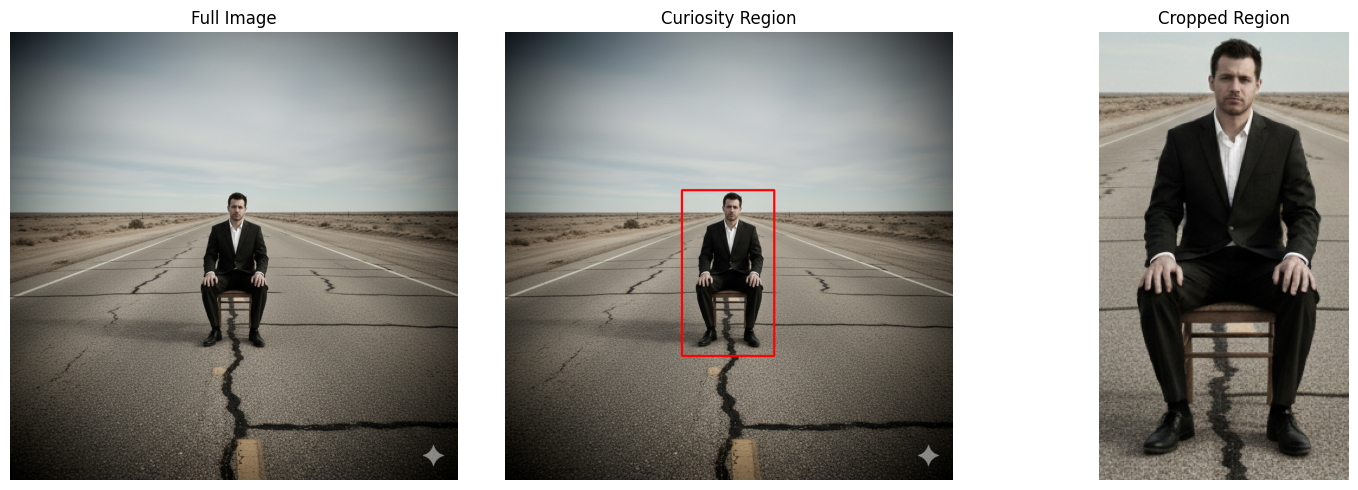


VQG on Curiosity Region:
Generated: a man sitting on a chair in the middle of a road
Human:     why is the man sitting like that?

VQA on Curiosity Region:
Q: What is unusual about this?
A: nothing


In [7]:
# 4. Apply to YOUR Curiosity Regions
# Load annotated image and test on curiosity region

def load_annotation(domain, img_name):
    """Load annotation for an image"""
    ann_path = Path(domain) / "annotations.json"
    with open(ann_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    key = 'annotations' if 'annotations' in data else 'images'
    for item in data[key]:
        if item['name'] == img_name:
            return item
    return None

# Test on img_001
domain = "Domain_1_Images"
img_name = "img_001.png"
img_path = Path(domain) / img_name

img = Image.open(img_path).convert("RGB")
ann_data = load_annotation(domain, img_name)

if ann_data and len(ann_data.get('annotations', [])) > 0:
    bbox = ann_data['annotations'][0]
    xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
    xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
    human_question = bbox['attributes'].get('question', '')
    curiosity_score = bbox['attributes'].get('curiosity_score', 0)
    
    print(f"Image: {img_name}")
    print(f"Human Question: {human_question}")
    print(f"Curiosity Score: {curiosity_score}/5")
    
    # Crop curiosity region
    img_array = np.array(img)
    cropped_region = img_array[ytl:ybr, xtl:xbr]
    cropped_img = Image.fromarray(cropped_region)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Full Image")
    axes[0].axis('off')
    
    img_with_box = np.array(img).copy()
    cv2.rectangle(img_with_box, (xtl, ytl), (xbr, ybr), (255, 0, 0), 3)
    axes[1].imshow(img_with_box)
    axes[1].set_title("Curiosity Region")
    axes[1].axis('off')
    
    axes[2].imshow(cropped_img)
    axes[2].set_title("Cropped Region")
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Generate question from cropped region
    print("\n" + "="*60)
    print("VQG on Curiosity Region:")
    print("="*60)
    inputs = blip_processor(cropped_img, return_tensors="pt")
    with torch.no_grad():
        out = blip_vqg_model.generate(**inputs, max_length=30, num_beams=3)
    generated_q = blip_processor.decode(out[0], skip_special_tokens=True)
    print(f"Generated: {generated_q}")
    print(f"Human:     {human_question}")
    
    # VQA on region
    print("\n" + "="*60)
    print("VQA on Curiosity Region:")
    print("="*60)
    test_q = "What is unusual about this?"
    inputs = blip_processor(cropped_img, test_q, return_tensors="pt")
    with torch.no_grad():
        out = blip_vqa_model.generate(**inputs, max_length=20)
    answer = blip_processor.decode(out[0], skip_special_tokens=True)
    print(f"Q: {test_q}")
    print(f"A: {answer}")
else:
    print("Annotation not found!")


In [8]:
# 5. Extract VLM Features for Training
# Useful for your curiosity prediction model

def extract_clip_features(image_path):
    """Extract CLIP features from an image"""
    img = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=img, return_tensors="pt")
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
    return features.numpy()

def extract_text_features(text):
    """Extract CLIP features from text"""
    inputs = clip_processor(text=text, return_tensors="pt")
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
    return features.numpy()

# Example: Extract features
img_path = "Domain_1_Images/img_001.png"
img_features = extract_clip_features(img_path)
print(f"Image features shape: {img_features.shape}")

if ann_data and len(ann_data.get('annotations', [])) > 0:
    question = ann_data['annotations'][0]['attributes'].get('question', '')
    if question:
        text_features = extract_text_features(question)
        print(f"Question features shape: {text_features.shape}")
        
        # Compute similarity
        img_feat = torch.tensor(img_features)
        txt_feat = torch.tensor(text_features)
        similarity = torch.cosine_similarity(img_feat, txt_feat)
        print(f"Image-Question similarity: {similarity.item():.4f}")


Image features shape: (1, 512)
Question features shape: (1, 512)
Image-Question similarity: 0.2631
Question features shape: (1, 512)
Image-Question similarity: 0.2631


In [9]:
# 6. Compare Generated vs Human Questions
# Test VQG on multiple curiosity regions

def compare_questions(image_path, bbox, human_question):
    """Compare VQG output with human annotation"""
    img = Image.open(image_path).convert("RGB")
    img_array = np.array(img)
    xtl, ytl = int(bbox['xtl']), int(bbox['ytl'])
    xbr, ybr = int(bbox['xbr']), int(bbox['ybr'])
    cropped = Image.fromarray(img_array[ytl:ybr, xtl:xbr])
    
    inputs = blip_processor(cropped, return_tensors="pt")
    with torch.no_grad():
        out = blip_vqg_model.generate(**inputs, max_length=40, num_beams=5)
    generated = blip_processor.decode(out[0], skip_special_tokens=True)
    
    return generated


def load_annotation_2(domain, img_name):
    """Load annotation for an image"""
    ann_path = Path(domain) / "annotations.json"
    # Try different encodings
    encodings = ['utf-8', 'utf-16', 'latin1', 'cp1252']
    
    for encoding in encodings:
        try:
            with open(ann_path, 'r', encoding=encoding) as f:
                data = json.load(f)
                key = 'annotations' if 'annotations' in data else 'images'
                for item in data[key]:
                    if item['name'] == img_name:
                        return item
                return None
        except (UnicodeDecodeError, json.JSONDecodeError):
            continue
    
    raise ValueError(f"Could not read {ann_path} with any of the attempted encodings: {encodings}")

# Test on a few images
test_images = [
    ("Domain_5_Images", "img_161.png"),
    ("Domain_5_Images", "img_162.png"),
]

print("="*80)
print("Question Generation Comparison")
print("="*80)

for domain, img_name in test_images:
    try:
        ann_data = load_annotation_2(domain, img_name)
        if ann_data and len(ann_data.get('annotations', [])) > 0:
            bbox = ann_data['annotations'][0]
            human_q = bbox['attributes'].get('question', '')
            img_path = Path(domain) / img_name
            
            generated_q = compare_questions(str(img_path), bbox, human_q)
            
            print(f"\nImage: {img_name}")
            print(f"Human:   {human_q}")
            print(f"VQG:     {generated_q}")
            print("-" * 80)
    except Exception as e:
        print(f"\nError processing {domain}/{img_name}: {str(e)}")
        print("-" * 80)

Question Generation Comparison

Image: img_161.png
Human:   why is a tree growing out of a road?
VQG:     a small tree growing out of a crack in a road
--------------------------------------------------------------------------------

Image: img_161.png
Human:   why is a tree growing out of a road?
VQG:     a small tree growing out of a crack in a road
--------------------------------------------------------------------------------

Image: img_162.png
Human:   why is there a flower out of concrete?
VQG:     a flower growing out of a crack in the road
--------------------------------------------------------------------------------

Image: img_162.png
Human:   why is there a flower out of concrete?
VQG:     a flower growing out of a crack in the road
--------------------------------------------------------------------------------
